In [28]:
import pprint
import numpy as np
import matplotlib.pyplot as plt
from simpleGenerator import Croupier

Импортируем класс Croupier, который отвечает за генерацию данных и создадим экземпляр класса с заданными значениями вероятности для нечестного кубика, а так же вероятности перехода с честного кубика на нечестный и на себя самого, и вероятности перехода с нечестного кубика на себя и на честный. Проверим что получаем выпавшие знаечение кубика, а так же метку кубика

In [2]:
casino = Croupier()
for i in range(10):
    print(casino())

(1, 'F')
(6, 'F')
(1, 'F')
(5, 'F')
(4, 'F')
(3, 'F')
(2, 'F')
(6, 'F')
(3, 'F')
(2, 'F')


Сгенерируем датасеты размером 300, 1 000 и 10 000

In [3]:
dataset300 = []
dataset300Labels = []

casino = Croupier()

for i in range(300):
    data, label = casino()
    dataset300.append(data)
    dataset300Labels.append(label)

In [4]:
dataset1000 = []
dataset1000Labels = []

casino = Croupier()

for i in range(1000):
    data, label = casino()
    dataset1000.append(data)
    dataset1000Labels.append(label)

In [ ]:
dataset10000 = []
dataset10000Labels = []

casino = Croupier()

for i in range(10000):
    data, label = casino()
    dataset1000.append(data)
    dataset1000Labels.append(label)

Ноль соответсвует честной кости, единица - нечестной.

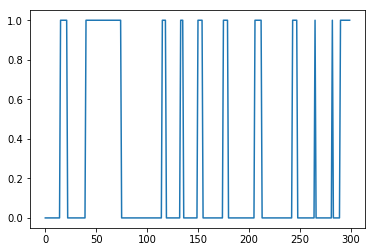

In [5]:
lab300 = [0 if l =='F' else 1 for l in dataset300Labels ]
plt.plot(lab300)

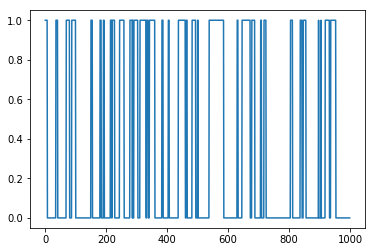

In [7]:
lab1000 = [0 if l =='F' else 1 for l in dataset1000Labels ]
plt.plot(lab1000)

In [ ]:
lab10000 = [0 if l =='F' else 1 for l in dataset10000Labels ]
plt.plot(lab10000)

Определим базовый класс алгоритма

In [8]:
class baseAlgo():
    def __init__(self, data):
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.array([0.95,0.05]), # to F, to U
            'U': np.array([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': 2/3,
            'U': 1/3
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [1/6 for i in range(6)],
            'U': [.1,.1,.1,.1,.1,.5]
        }

## Алгоритм Витерби

In [9]:
class algorithmViterbi(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        self.v = []
        self.ptr = []
        
        self.path = None
        self.probability = None
        
        
    def step(self,index):
        self.v.append([])
        self.ptr.append([])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            probability = observedProbability*np.max( self.v[index-1] * self.transitionsProbability[state])
            ptr = 'F' if np.argmax(self.v[index-1] * self.transitionsProbability[state]) == 0 else 'U'
            self.v[-1].append(probability)
            self.ptr[-1].append(ptr)
            
    
    def initialization(self):
        self.v.append([])
        self.ptr.append(['F','U'])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[0] - 1]
            probability = observedProbability*self.startProbability[state]
            self.v[0].append(probability)
        
        for i in range(1, self.L): 
            self.step(i)
        
        self.probability = max(self.v[-1])
        self.path = [ 'F' if np.argmax(self.v[-1]) == 0 else 'U' ]
        
        for i in range(self.L-1,0,-1):
            self.path.append(self.ptr[i][0 if self.path[-1] == 'F' else 1])
        
        self.path = self.path[::-1]
    
    def returnProbability(self):
        if self.probability != None: return self.probability
    
    def __call__(self):
        if self.path == None: self.initialization()
        return self.path

RESULT: 0.8233333333333334
Probability: 1.407157993332004e-237


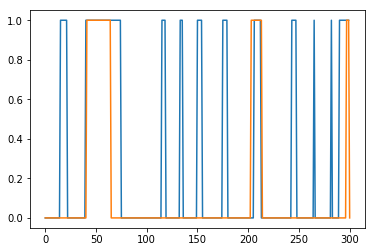

In [11]:
hackCasinoViterbi = algorithmViterbi(dataset300)
result = hackCasinoViterbi()
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab300)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab300,res)])/len(lab300)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

RESULT: 0.719
Probability: 0.0


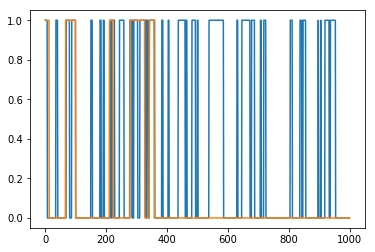

In [12]:
hackCasinoViterbi = algorithmViterbi(dataset1000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset1000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab1000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab1000,res)])/len(lab1000)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

In [ ]:
hackCasinoViterbi = algorithmViterbi(dataset10000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset10000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab1000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab10000,res)])/len(lab10000)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

Из графиков с 1000 и 10 000 экземпляров видно, что накапление машинной ошибки ведет к тому, что алгоритм уже не в состояние выдавать ненулевые значения. Чтобы избежать этого, перейдем в логарифмический масштаб

In [13]:
class baseAlgoLog():
    def __init__(self, data):
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.log([0.95,0.05]), # to F, to U
            'U': np.log([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': np.log(2/3),
            'U': np.log(1/3)
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': np.log([1/6 for i in range(6)]),
            'U': np.log([.1,.1,.1,.1,.1,.5])
        }

In [14]:
class algorithmViterbiLog(baseAlgoLog):
    def __init__(self, data):
        baseAlgoLog.__init__(self, data)
        
        self.v = []
        self.ptr = []
        
        self.path = None
        self.probability = None
        
        
    def step(self,index):
        self.v.append([])
        self.ptr.append([])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            probability = observedProbability + np.max( self.v[index-1] + self.transitionsProbability[state])
            ptr = 'F' if np.argmax(self.v[index-1] + self.transitionsProbability[state]) == 0 else 'U'
            self.v[-1].append(probability)
            self.ptr[-1].append(ptr)
            
    
    def initialization(self):
        self.v.append([])
        self.ptr.append(['F','U'])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[0] - 1]
            probability = observedProbability + self.startProbability[state]
            self.v[0].append(probability)
        
        for i in range(1, self.L): 
            self.step(i)
        
        self.probability = np.e**max(self.v[-1])
        self.path = [ 'F' if np.argmax(self.v[-1]) == 0 else 'U' ]
        
        for i in range(self.L-1,0,-1):
            self.path.append(self.ptr[i][0 if self.path[-1] == 'F' else 1])
        
        self.path = self.path[::-1]
    
    def returnProbability(self):
        if self.probability != None: return self.probability
    
    def __call__(self):
        if self.path == None: self.initialization()
        return self.path
        

RESULT: 0.8233333333333334
Probability: 1.4071579933302673e-237


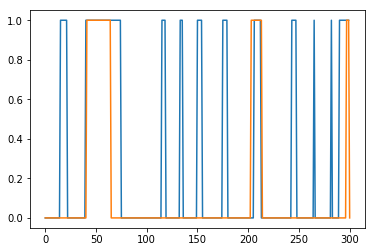

In [16]:
hackCasinoViterbiLog = algorithmViterbiLog(dataset300)
result = hackCasinoViterbiLog()
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab300)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab300,res)])/len(lab300)))
print('Probability: {}'.format(hackCasinoViterbiLog.returnProbability()))

RESULT: 0.841
Probability: 1.4071579933302673e-237


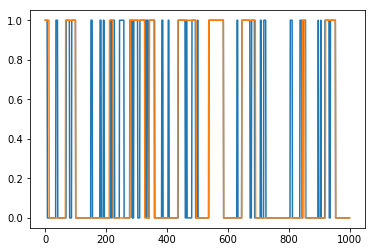

In [17]:
hackCasinoViterbi = algorithmViterbiLog(dataset1000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset1000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab1000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab1000,res)])/len(lab1000)))
print('Probability: {}'.format(hackCasinoViterbiLog.returnProbability()))

In [ ]:
hackCasinoViterbi = algorithmViterbiLog(dataset10000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset10000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab10000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab10000,res)])/len(lab10000)))
print('Probability: {}'.format(hackCasinoViterbiLog.returnProbability()))

## Алгорит прямого и обратного хода, постериорное декадирование

In [22]:
class forwardAlgorithm(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        self.f = []
        self.pathProbability = None
    
    def step(self, index):
        self.f.append([])
        previuosState = self.f[-2]
        for i,state in enumerate(self.states):
            transitionProbability = np.array([val[i] for val in self.transitionsProbability.values()])
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            
            """
            observedProbability: вероятсность наблюдения при текущем состояние
            transitionProbability: вероятность перехода с кубика на кубик
            """
            probability = observedProbability * sum(previuosState * transitionProbability)
            self.f[-1].append(probability)
    
    def __call__(self):
        if self.pathProbability == None: self.initialization()
        return self.pathProbability
    
    def initialization(self):
        # Init
        self.f.append([self.startProbability[state] for state in self.states] * 
                      np.array([self.diceValueProbability[state][self.data[0] - 1] for state in self.states]))
        # Recursion
        for i in range(1,self.L):
            self.step(i)
        self.pathProbability = sum(self.f[-1])

In [23]:
class backwardAlgorithm(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        self.b = []
        self.pathProbability = None
    
    def step(self, index):
        self.b.append([])
        observedProbability =  np.array([val[self.data[index]-1] for val in self.diceValueProbability.values()])
        nextState = self.b[-2]
        for state in self.states: # first fair then unfair
            transitionProbability = self.transitionsProbability[state]            
            probability = sum(transitionProbability * observedProbability * nextState)
            self.b[-1].append(probability)
    
    def __call__(self):
        if self.pathProbability == None: self.initialization()
        return self.pathProbability
    
    def initialization(self):
        
        self.b.append([1 for state in self.states])
        #Recursion
        for i in range(self.L-1,0,-1):
            self.step(i)
            
        # Finish # перевернуть b
        self.b = self.b[::-1]
        self.pathProbability = sum(self.b[0])

In [27]:
backwardHack = backwardAlgorithm(dataset300)
b=backwardHack()
forwardHack = forwardAlgorithm(dataset300)
f=forwardHack()

print('FORWARD: {}\nBACKWARD: {}\n'.format(f,b))

FORWARD: 1.4529348078157115e-229
BACKWARD: 1.5829521045884982e-228



Проведем проверку

In [29]:
pprint.pprint([sum(f*np.array(b)) for f, b in zip(forwardHack.f, backwardHack.b)])

[1.4529348078157263e-229,
 1.4529348078157262e-229,
 1.4529348078157262e-229,
 1.4529348078157262e-229,
 1.4529348078157262e-229,
 1.452934807815726e-229,
 1.4529348078157262e-229,
 1.452934807815726e-229,
 1.4529348078157258e-229,
 1.4529348078157254e-229,
 1.4529348078157254e-229,
 1.4529348078157254e-229,
 1.4529348078157254e-229,
 1.4529348078157254e-229,
 1.4529348078157254e-229,
 1.4529348078157254e-229,
 1.4529348078157254e-229,
 1.4529348078157258e-229,
 1.4529348078157258e-229,
 1.4529348078157258e-229,
 1.4529348078157258e-229,
 1.452934807815726e-229,
 1.4529348078157258e-229,
 1.4529348078157256e-229,
 1.4529348078157256e-229,
 1.4529348078157258e-229,
 1.4529348078157258e-229,
 1.4529348078157258e-229,
 1.452934807815726e-229,
 1.4529348078157258e-229,
 1.4529348078157256e-229,
 1.4529348078157254e-229,
 1.4529348078157256e-229,
 1.4529348078157254e-229,
 1.4529348078157254e-229,
 1.4529348078157252e-229,
 1.452934807815725e-229,
 1.452934807815725e-229,
 1.452934807815725

In [48]:
class PosteriorDecoding(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        # For forward
        self.f = []
        self.pathProbability = None
        # for backward
        self.b = []
        # For decoding
        self.conditionalProbability = None
        
    def stepForward(self, index):
        self.f.append([])
        previuosState = self.f[-2]
        for i, state in enumerate(self.states):
            transitionProbability = np.array([val[i] for val in self.transitionsProbability.values()])
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            probability = observedProbability * sum(previuosState * transitionProbability)
            self.f[-1].append(probability)
    
    def stepBackward(self, index):
        ### backward step
        self.bCurrent = []
        self.b.append([])
        nextState = self.b[-2]
        observedProbability =  np.array([val[self.data[index]-1] for val in self.diceValueProbability.values()])
        for state in self.states: # first fair then unfair
            transitionProbability = self.transitionsProbability[state]
            probability = sum(transitionProbability * observedProbability * nextState)
            self.b[-1].append(probability)
        
    
    def __call__(self):
        if self.conditionalProbability == None: self.initialization()
        return self.conditionalProbability
    
    def initialization(self):
        ### Forward part ###
        # Init
        self.f.append([self.startProbability[state] for state in self.states] * 
                      np.array([self.diceValueProbability[state][self.data[0] - 1] for state in self.states]))
        # Recursion
        for i in range(1,self.L):
            self.stepForward(i)
        self.pathProbability = sum(self.f[-1])
        ### ____________ ###
        
        ### Backward and decoding ###
        self.conditionalProbability = []
        self.bPrevious = [1,1]
        
        self.b.append([1 for state in self.states])
        for i in range(self.L-1,0,-1):
            self.stepBackward(i)
            
        self.b = self.b[::-1]
        for i in range(self.L):
            conProb = self.f[i][0]*self.b[i][0] / self.pathProbability
            self.conditionalProbability.append(conProb)

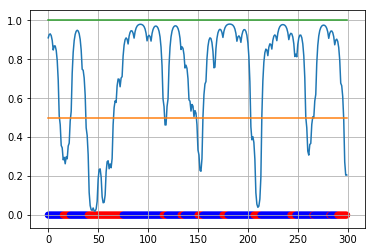

In [54]:
PosteriorHack = PosteriorDecoding(dataset300)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset300Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars


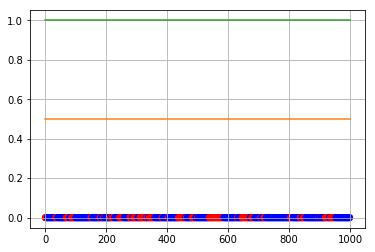

In [56]:
PosteriorHack = PosteriorDecoding(dataset1000)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset1000Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

In [ ]:
PosteriorHack = PosteriorDecoding(dataset10000)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset10000Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

Из-за потери машиной точности, графики на последовательностях 1000 и 10 000 построить не получилось. Чтобы исправить эту проблему применим масштабирование для алгоритма декодирования

In [78]:
def multiply(n):
    """
    Вспомогательная функция, которая перемножает элементы массива
    """
    total = 1
    for i in n: total *= i
    return total

 ( Не очень понятно как потом учесть масштабирование при нахождение условных вероятностей )

In [87]:
class PosteriorDecodingScaled(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        # For forward
        self.f = []
        self.pathProbability = None
        # for backward
        self.b = []
        # For decoding
        self.conditionalProbability = None
        # For scaling
        self.scaledConstF = []
        self.scaledConstB = []
        
    def stepForward(self, index):
        self.f.append([])
        previuosState = self.f[-2]
        for i, state in enumerate(self.states):
            transitionProbability = np.array([val[i] for val in self.transitionsProbability.values()])
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            probability = observedProbability * sum(previuosState * transitionProbability)
            self.f[-1].append(probability)
        
        self.scaledConstF.append(max(self.f[-1]))
        self.f[-1] = self.f[-1]/self.scaledConstF[-1]
    
    def stepBackward(self, index):
        ### backward step
        self.bCurrent = []
        self.b.append([])
        nextState = self.b[-2]
        observedProbability =  np.array([val[self.data[index]-1] for val in self.diceValueProbability.values()])
        for state in self.states: # first fair then unfair
            transitionProbability = self.transitionsProbability[state]
            probability = sum(transitionProbability * observedProbability * nextState)
            self.b[-1].append(probability)
        
        self.scaledConstB.append(max(self.b[-1]))
        self.b[-1] = self.b[-1]/self.scaledConstB[-1]
        
    
    def __call__(self):
        if self.conditionalProbability == None: self.initialization()
        return self.conditionalProbability
    
    def initialization(self):
        ### Forward part ###
        # Init
        self.f.append([self.startProbability[state] for state in self.states] * 
                      np.array([self.diceValueProbability[state][self.data[0] - 1] for state in self.states]))
        
        self.scaledConstF.append(max(self.f[-1]))
        self.f[-1] = self.f[-1]/self.scaledConstF[-1]
        # Recursion
        for i in range(1,self.L):
            self.stepForward(i)
        #self.pathProbability = sum(self.f[-1]) * multiply(PosteriorHack.scaledConstF)
        self.pathProbability = sum(self.f[-1]) #* multiply(PosteriorHack.scaledConstF)
        ### ____________ ###
        
        ### Backward and decoding ###
        self.conditionalProbability = []
        
        self.b.append([1 for state in self.states])
        self.scaledConstB.append(1)
        for i in range(self.L-1,0,-1):
            self.stepBackward(i)
            
        self.b = self.b[::-1]
        for i in range(self.L):
            #conProb = self.f[i][0]*self.b[i][0] * self.scaledConstB[i]* self.scaledConstF[i] / self.pathProbability
            conProb = self.f[i][0]*self.b[i][0] / self.pathProbability
            self.conditionalProbability.append(conProb)

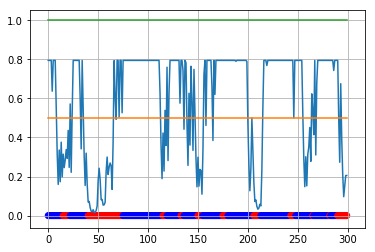

In [88]:
PosteriorHack = PosteriorDecodingScaled(dataset300)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset300Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
# Настроить оси
ax.plot([.5 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])
#ax.plot([0 for i in conditionsProbs])

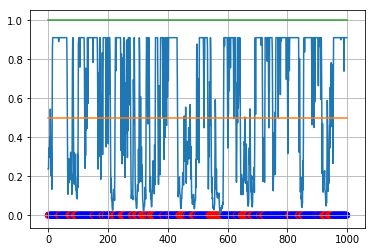

In [89]:
PosteriorHack = PosteriorDecodingScaled(dataset1000)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset1000Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

In [ ]:
PosteriorHack = PosteriorDecodingScaled(dataset10000)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset10000Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

## Алгоритм Баума-Велша

In [ ]:
class parametrs:   # Сделаь универсальнее
    def __init__(self, data):
        
        self.isFitted = False
        
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.array([0.5,0.5]), # to F, to U
            'U': np.array([0.5,0.5]) # to F, to U
        }
        
        self.startProbability = {
            'F': 1/2,
            'U': 1/2
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [1/6 for i in range(6)],
            'U': [1/6 for i in range(6)]
        }

In [ ]:
class BaumWelchTrainig(parametrs):
    def __init__(self, data):
        parametrs.__init__(self, data)

        # For forward
        self.f = []
        self.pathProbability = None
        # for backward
        self.b = []
        # For decoding
        self.conditionalProbability = None
        
        self.epselon = 10**-100
        self.iterationNumber = 20
        
    def stepForward(self, index):
        self.f.append([])
        for state in self.states:
            transitionProbability = self.transitionsProbability[state]
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            previuosState = self.f[index-1]
            probability = observedProbability * sum(previuosState * transitionProbability)
            self.f[-1].append(probability)
    
    def stepBackward(self, index):
        ### backward step
        for state in self.states: # first fair then unfair
            transitionProbability = self.transitionsProbability[state]
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            nextState = self.b[-1]
            probability = sum(transitionProbability * observedProbability * nextState)
            self.b.append(probability)
            
    def initializationForwardBack(self):
        ### Forward part ###
        # Init
        self.f.append([self.startProbability[state] for state in self.states]) # Не уверен
        # Recursion
        for i in range(1,self.L):
            self.stepForward(i)
        self.pathProbability = sum(self.f[-1])
        self.b.append([1,1])
        ### Backward part ###
        for i in range(self.L-1,1,-1): # С двойки?
            self.stepBackward(i)
    
    
    def __call__(self):
        if self.isFitted == False: self.initialization()
        print('FITTED')
        print('Parametrs')
        print('TransitionsProbability: {}'.format(self.transitionsProbability))
        print('startProbability: {}'.format(self.startProbability))
        print('diceValueProbability: {}'.format(self.diceValueProbability))
    
    def initialization(self):
        prLog = 10000000000000
        for step in range(self.iterationNumber):
            # Calculate f and b
            self.f = []
            self.pathProbability = 0
            self.b = []
            self.initializationForwardBack()
            # Change paramets
            self.changeParametrs()
            currentLog = self.logLikelihood()
            if (abs(currentLog - prLog) < self.epselon: break
            prLog = currentLog
    
    
    def logLikelihood(self):
        return np.log(self.pathProbability)
    
    def changeParametrs(self):
        Afair2fair = sum([ self.f[0][i] * self.b[0][i+1] *
                          self.transitionProbability['F'][0] *
                          self.diceValueProbability['F'[data[i + 1] -1]
                     for i in range(1, self.L)]/self.pathProbability
                          
        Afair2unfair = sum([ self.f[0][i] * self.b[1][i+1] *
                          self.transitionProbability['F'][1] *
                          self.diceValueProbability['F'[data[i + 1] -1]
                     for i in range(1, self.L)]/self.pathProbability
        
        Aunfair2fair = sum([ self.f[1][i] * self.b[0][i+1] *
                          self.transitionProbability['U'][0] *
                          self.diceValueProbability['U'[data[i + 1] -1]
                     for i in range(1, self.L)]/self.pathProbability
                            
        Aunfair2unfair = sum([ self.f[1][i] * self.b[1][i+1] *
                          self.transitionProbability['U'][1] *
                          self.diceValueProbability['U'[data[i + 1] -1]
                     for i in range(1, self.L)]/self.pathProbability
                              
        # Add E